# hist_emis
## Purpose: download historical emissions time series and input into FaIR
- Luckily, the creators of FaIR already aggregated emissions data from PRIMAP, CEDS, GFEDS, and other sources. This means the data is already cleaned and organized in a nice .csv file for us
- Emissions span 1750 to 2022
- Data credit: Smith, C. (2024). FaIR calibration data (1.4.1). Zenodo. https://doi.org/10.5281/zenodo.10566813
    - Filepath: `fair_calibrate/output/fair-2.1.3/v1.4/all-2022/emissions/all_scaled_1750-2022.csv` (need to open `fair_calibrate.zip` to view data)
    - Also available to download from https://github.com/WoodwellRisk/FaIR/blob/main/data/all_scaled_1750-2022.csv

### 01/26/24, Erica Simon

### Imports

In [402]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Create instance

In [403]:
f = FAIR()

## Define time horizon

In [404]:
f.define_time(1750, 2022, 1)

## Define scenarios

In [405]:
f.define_scenarios(['s1'])

## Define configs

In [406]:
f.define_configs(['c1'])

## Define species & properties

In [407]:
species_configs = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv',
    known_hash = '4f9d25b21d632cf35953842a627db4b1612b465f68b2a824afff017a7390053b',
)

In [408]:
species, properties = read_properties(filename=species_configs)

# removed in examples from fair-calibrate repo, specifically because 'future projections aren't available'
species.remove("Halon-1202")
species.remove("NOx aviation")

f.define_species(species, properties)

## Create data arrays

In [409]:
# create empty emission and temp arrays
f.allocate()   

## Fill data arrays
- Emissions & forcings
- Climate configs
- Species configs
- Initial conditions

### Emissions

From PRIMAP Zenodo:

- "**HISTCR**: In this scenario **country-reported data** (CRF, BUR / NIR / NC / UNFCCCDI) are prioritized over third-party data (CDIAC, FAO, Andrew, EDGAR, BP)."

- "**HISTTP**: In this scenario **third-party data** (CDIAC, FAO, Andrew, EDGAR, BP) are prioritized over country-reported data (CRF, BUR / NIR / NC / UNFCCCDI)"

Data is provided in output of: Smith, C. (2024). FaIR calibration data (1.4.1). Zenodo. https://doi.org/10.5281/ZENODO.10566813

Since reported emission data tend to be underestimates, Smith scales the emissions to reproduce observed concentrations. More information on scaling rationale and methods can be found in `fair_calibrate/input/fair-2.1.3/v1.4/all-2022/calibration/13_check-scalings.py`

In [410]:
df_emis = pd.read_csv('~/data/all_scaled_1750-2022.csv')

# remove 'Emissions|' from variable name
for i in range(len(df_emis.variable.values)): 
    df_emis.variable.values[i] = df_emis.variable.values[i][10:]

# rename to match FaIR spceies
df_emis.loc[df_emis.variable == 'CO2|AFOLU', 'variable'] = 'CO2 AFOLU'
df_emis.loc[df_emis.variable == 'CO2|Energy and Industrial Processes', 'variable'] = 'CO2 FFI'

df_emis.head()

,model,scenario,region,variable,unit,1750,1751,1752,1753,1754,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Historical,GCP+CEDS+PRIMAP+GFED,World,BC,Mt BC/yr,2.096766,2.071972,2.067178,2.070382,2.098586,...,7.842259,7.934828,7.926371,7.568060,7.562319,7.459095,7.781842,6.525021,6.871947,6.701702
1,Historical,GCP+CEDS+PRIMAP+GFED,World,C2F6,kt C2F6/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.003458,1.035565,0.933936,0.979945,0.996980,0.996764,1.062577,1.106550,1.160588,1.167145
2,Historical,GCP+CEDS+PRIMAP+GFED,World,C3F8,kt C3F8/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.314138,0.323186,0.304124,0.319107,0.324656,0.324586,0.346019,0.360340,0.377938,0.380074
3,Historical,GCP+CEDS+PRIMAP+GFED,World,C4F10,kt C4F10/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070672,0.070641,0.067024,0.070327,0.071550,0.071536,0.076260,0.079417,0.083292,0.083759
4,Historical,GCP+CEDS+PRIMAP+GFED,World,C5F12,kt C5F12/yr,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.035588,0.031141,0.030030,0.031513,0.032065,0.032062,0.034184,0.035603,0.037338,0.037545


In [411]:
for var in df_emis['variable']:
    if var in f.species:
        emis = df_emis[df_emis['variable'] == var].values[0][5:277].reshape(272,1)
        fill(f.emissions, emis, scenario='s1', specie=var)

We also need to see which other species are not included in this dataset, excluding species that are calculated from other values.

In [412]:
for element in f.species:
    if element not in df_emis['variable'].values:
        if f.properties[element]['input_mode'] != 'calculated':
            print(element)

Solar
Volcanic


Fill solar & volcanic forcings

In [413]:
solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

In [414]:
volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

In [415]:
df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col="timebounds")

In [416]:
# only want years 1750-2022
s_yr_list = list(range(2023, 2301))
v_yr_list = list(range(2023, 2102))

df_solar = df_solar.drop(s_yr_list)
df_volcanic = df_volcanic.drop(v_yr_list)

In [417]:
fill(f.forcing, df_volcanic, scenario='s1', specie='Volcanic')
fill(f.forcing, df_solar, scenario='s1', specie='Solar')

### Climate configs

In [418]:
fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='c1')
fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='c1')
fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='c1')

### Species configs

In [419]:
f.fill_species_configs()

### Initial conditions

In [420]:
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)   # f.temperature refers to temperature rise above PI (288 K)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)

## Run

In [421]:
f.run()

Running 1 projections in parallel:   0%|          | 0/272 [00:00<?, ?timesteps/s]

## Analyze output

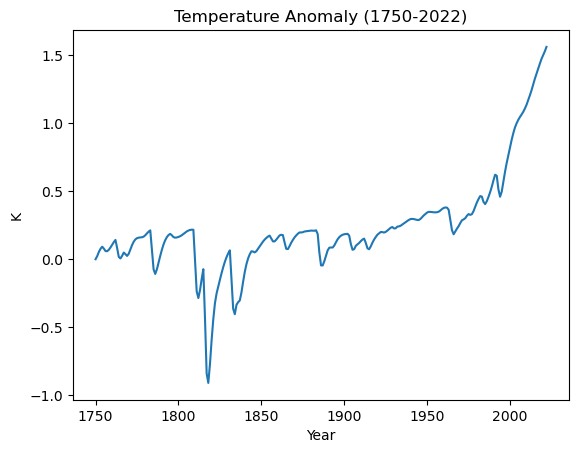

In [422]:
plt.plot(f.timebounds, f.temperature.loc[dict(scenario='s1', layer=0)])
plt.xlabel('Year')
plt.ylabel('K')
plt.title('Temperature Anomaly (1750-2022)')
plt.show()

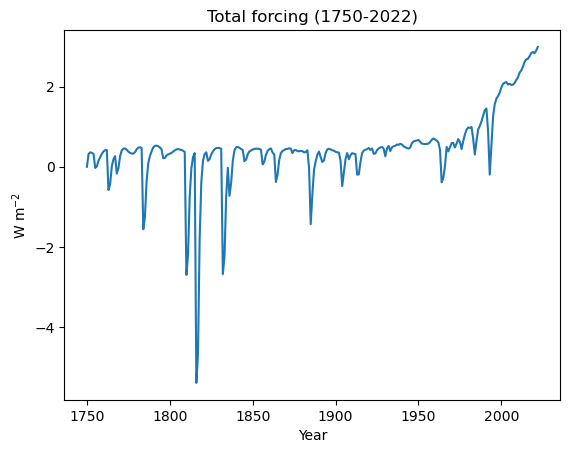

In [423]:
plt.plot(f.timebounds, f.stochastic_forcing.loc[dict(scenario='s1')])
plt.xlabel('Year')
plt.ylabel('W m$^{-2}$')
plt.title('Total forcing (1750-2022)')
plt.show()

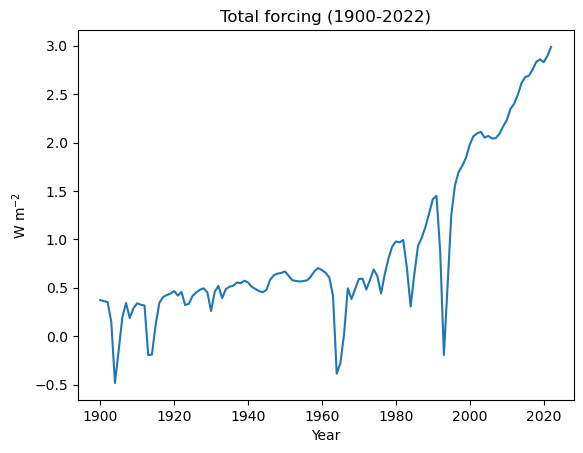

In [447]:
plt.plot(f.timebounds[150:], f.stochastic_forcing.loc[dict(scenario='s1')][150:])
plt.xlabel('Year')
plt.ylabel('W m$^{-2}$')
plt.title('Total forcing (1900-2022)')
plt.show()

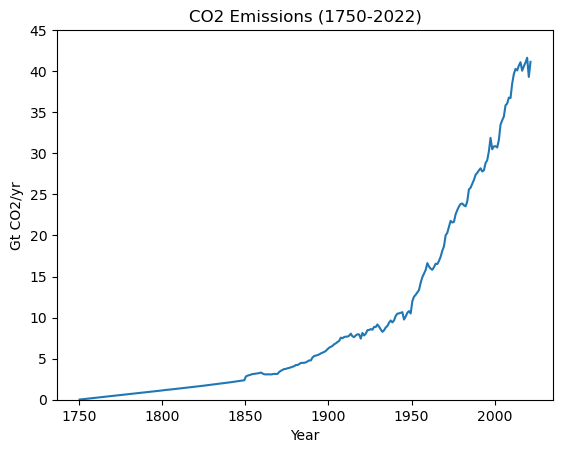

In [428]:
plt.plot(f.timepoints, f.emissions.loc[dict(specie='CO2', scenario='s1')])
plt.xlabel('Year')
plt.ylabel('Gt CO2/yr')
plt.ylim(0, 45)
plt.title('CO2 Emissions (1750-2022)')
plt.show()

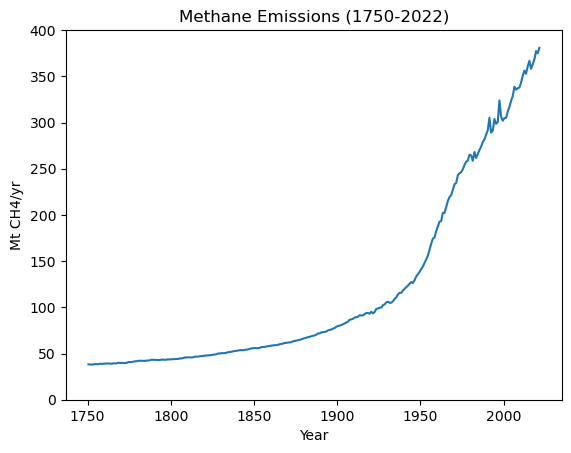

In [433]:
plt.plot(f.timepoints, f.emissions.loc[dict(specie='CH4', scenario='s1')])
plt.xlabel('Year')
plt.ylabel('Mt CH4/yr')
plt.ylim(0,400)
plt.title('Methane Emissions (1750-2022)')
plt.show()

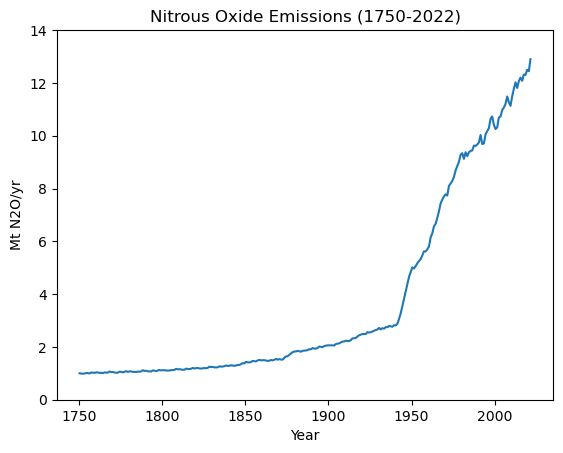

In [452]:
plt.plot(f.timepoints, f.emissions.loc[dict(specie='N2O', scenario='s1')])
plt.xlabel('Year')
plt.ylabel('Mt N2O/yr')
plt.ylim(0,14)
plt.title('Nitrous Oxide Emissions (1750-2022)')
plt.show()

### Volcanoes!

1815: eruption of Mount Tambora in Indonesia

1816: ["The Year Without Summer"](https://www.nps.gov/articles/000/1816-the-year-without-summer.htm#:~:text=The%20eruption%20of%20Mount%20Tambora,cloud%20the%20size%20of%20Australia.)

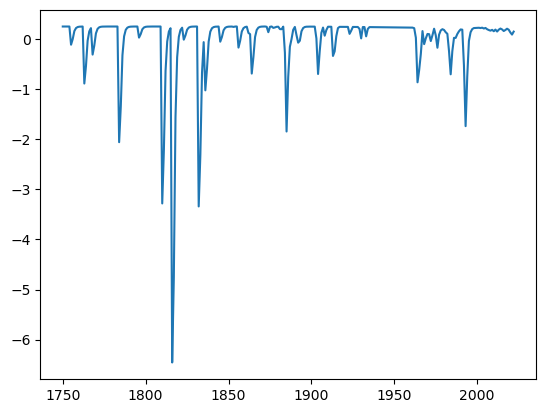

In [426]:
plt.plot(df_volcanic)